# Master Project

### Set up

In [916]:
### Import libraries

# The code is written in an old version of tensor flow
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
import math
from tqdm import tqdm_notebook
import pandas as pd

# Representation of real numbers 
real_type = tf.float32

### Data

**Heston Model MC samples**

In [1089]:
### Import Heston data
assets = pd.read_csv('/Users/ninamcclure/Desktop/DSMMasterProject23/Data/data_020623/malliavin_asset_prices_11.csv', header = None)
prices = pd.read_csv('/Users/ninamcclure/Desktop/DSMMasterProject23/Data/data_020623/malliavin_option_prices_11.csv', header = None)
delta_test = pd.read_csv('/Users/ninamcclure/Desktop/DSMMasterProject23/Data/data_020623/malliavin_deltas_11.csv', header = None)

assets = np.array(assets)
prices = np.array(prices)
delta_test = np.array(delta_test)

In [1091]:
### Split training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, dxdy_train, dxdy_test = train_test_split(assets, prices, delta_test, test_size=0.20, random_state=42)

In [1092]:
### Check shape
for var in [X_train, X_test, y_train, y_test, dxdy_train, dxdy_test]:
    print(var.shape)

(800, 1)
(200, 1)
(800, 1)
(200, 1)
(800, 1)
(200, 1)


Text(0.5, 1.0, 'Heston Option Prices: Test Set')

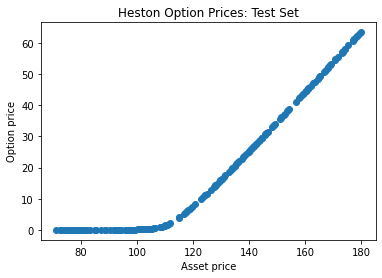

In [941]:
plt.scatter(X_test, y_test)
plt.xlabel("Asset price")
plt.ylabel("Option price")
plt.title("Heston Option Prices: Test Set")

**TF functions**:

**tf.compat.v1.get_variable()**: creates a new variable and adds it to the TensorFlow graph. It takes an initial value as input and returns a TensorFlow variable object that can be used in subsequent computations.

**tf.placeholder()**: Inserts a placeholder for a tensor

**tf.keras.initializers.variance_scaling()**: used to initialise weights

**tf.zeros_initializer()**: initialises a tensor populated with zeros

**@ operator**: performs matrix multiplication

In [756]:
def vanilla_net(input_dim, hidden_units, hidden_layers, seed):          
    '''
    Input:
        input_dim       - dimension of inputs (1 in BS case) (data) [int]
        hidden_units    - units in hidden layers, assumed constant [int]
        hidden_layers   - number of hidden layers [int]
    Output:
        xs - inputs (asset prices)    [(n, input_dim) tf.Tensor] where n is # observations
        ws - weights                  [list of tf.Variables of length = (hidden_layers + 1), 1st element (input_dim, hidden_units), last element (hidden_units, 1), others are (hidden_units, hidden_units)]
        bs - biases                   [list of tf.Variables of length = (hidden_layers + 1), last element (1, ), others are (hidden_units, )] 
        zs - layer outputs            [list of tf.Tensors of length = (hidden_layers + 2), 1st element = xs, last element = ys, others are (n, hidden_units)
        ys - prediction               [(n, 1) tf.Tensor] where n is # observations
  '''            
    
    # input layer (this will be the prices)  
    xs = tf.placeholder(shape=[None, input_dim], dtype=real_type)
       
    # connection weights and biases of hidden layers
    ws = [None]
    bs = [None]
    # layer 0 (input) has no parameters
    
    # layer 0 = input layer
    zs = [xs] # see equation 3), l=0
    
    # first hidden layer (index 1)
    # weight matrix
    ws.append(tf.get_variable("w1", [input_dim, hidden_units], \
        initializer = tf.variance_scaling_initializer(), dtype=real_type))
    # bias vector
    bs.append(tf.get_variable("b1", [hidden_units], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # graph
    zs.append(zs[0] @ ws[1] + bs[1]) # see equation 3), l=1
    
    # second hidden layer (index 2) to last (index hidden_layers)
    for l in range(1, hidden_layers): 
        ws.append(tf.get_variable("w%d"%(l+1), [hidden_units, hidden_units], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
        bs.append(tf.get_variable("b%d"%(l+1), [hidden_units], \
            initializer = tf.zeros_initializer(), dtype=real_type))
        # Softplus activation
        zs.append(tf.nn.softplus(zs[l]) @ ws[l+1] + bs[l+1]) # see equation 3), l=2..L-1

    # output layer (index hidden_layers+1)
    ws.append(tf.compat.v1.get_variable("w"+str(hidden_layers+1), [hidden_units, 1], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
    bs.append(tf.get_variable("b"+str(hidden_layers+1), [1], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # see equation 3), l=L
    # Softplus activation
    zs.append(tf.nn.softplus(zs[hidden_layers]) @ ws[hidden_layers+1] + bs[hidden_layers+1]) 

    # result = output layer
    ys = zs[hidden_layers+1]
    
    # return input layer, (parameters = weight matrices and bias vectors), 
    # [all layers] and output layer
    return xs, (ws, bs), zs, ys

In [65]:
# Test vanilla_net function
tf.reset_default_graph()
Xs, (Ws, Bs), Zs, Ys = vanilla_net(input_dim = 1, hidden_units = 20, hidden_layers = 4, seed = None)

In [66]:
# Input shape
print(Xs.shape)

(?, 1)


In [67]:
# Weights dimension
Ws

[None,
 <tf.Variable 'w1:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'w2:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'w3:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'w4:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'w5:0' shape=(20, 1) dtype=float32_ref>]

In [68]:
# Biases dimension
Bs

[None,
 <tf.Variable 'b1:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'b3:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'b4:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'b5:0' shape=(1,) dtype=float32_ref>]

In [69]:
# Hidden layers shape
Zs

[<tf.Tensor 'Placeholder:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'add:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'add_1:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'add_2:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'add_3:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'add_4:0' shape=(?, 1) dtype=float32>]

In [70]:
# Output shape
print(Ys.shape)

(?, 1)


**Back-prop and twin net**

In [132]:
# compute d_output/d_inputs by (explicit) backprop in vanilla net
def backprop(weights_and_biases, zs):                
    '''
      Input:
          weights_and_biases - 2nd output of vanilla_net(), input together as list
          zs                 - 3rd output of vanilla_net() 
      Output:
          xbar - predicted differentials   [(n, 1)) tf.Tensor] where n is # observations
    '''       
    ws, bs = weights_and_biases
    L = len(zs) - 1
    
    # backpropagation, see equation (4), l=L..1
    zbar = tf.ones_like(zs[L]) # zbar_L = 1
    for l in range(L-1, 0, -1):
        # Softplus activation
        zbar = (zbar @ tf.transpose(ws[l+1])) * tf.nn.sigmoid(zs[l]) # see equation (4)       
    # for l=0
    zbar = zbar @ tf.transpose(ws[1]) # see equation (4)
    
    xbar = zbar # xbar = zbar_0
    
    # dz[L] / dx
    return xbar    

In [45]:
# Test backprop function
Xbar = backprop((Ws, Bs), Zs)

Tensor("add_3:0", shape=(?, 20), dtype=float32)
Tensor("ones_like_3:0", shape=(?, 1), dtype=float32)
Tensor("add_2:0", shape=(?, 20), dtype=float32)
Tensor("mul_12:0", shape=(?, 20), dtype=float32)
Tensor("add_1:0", shape=(?, 20), dtype=float32)
Tensor("mul_13:0", shape=(?, 20), dtype=float32)
Tensor("add:0", shape=(?, 20), dtype=float32)
Tensor("mul_14:0", shape=(?, 20), dtype=float32)


In [46]:
# Shape of output
Xbar

<tf.Tensor 'matmul_24:0' shape=(?, 1) dtype=float32>

In [47]:
# combined graph for valuation and differentiation
def twin_net(input_dim, hidden_units, hidden_layers, seed):
    '''
    This function combines the vanilla_net() and backprop() functions to build the twin network.
    
    Input:
        input_dim       - dimension of inputs (1 in BS case) (data) [int]
        hidden_units    - units in hidden layers, assumed constant [int]
        hidden_layers   - number of hidden layers [int]
        seed            - seed for reproducibility [int or None]
    Output:
        xs - inputs  (asset prices)             [(n, input_dim) tf.Tensor] where n is # observations
        ys - value prediction (option prices)   [(n, 1) tf.Tensor]
        xbar - predicted differentials          [(n, 1)) tf.Tensor] 

  '''     
    # first, build the feedforward net
    xs, (ws, bs), zs, ys = vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # then, build its differentiation by backprop
    xbar = backprop((ws, bs), zs)
    
    # return input x, output y and differentials d_y/d_z
    return xs, ys, xbar

In [48]:
# Test twin_net function
tf.reset_default_graph()
Xs, Ys, Xbar = twin_net(input_dim = 10, hidden_units = 20, hidden_layers = 4, seed = None)

Tensor("add_3:0", shape=(?, 20), dtype=float32)
Tensor("ones_like:0", shape=(?, 1), dtype=float32)
Tensor("add_2:0", shape=(?, 20), dtype=float32)
Tensor("mul:0", shape=(?, 20), dtype=float32)
Tensor("add_1:0", shape=(?, 20), dtype=float32)
Tensor("mul_1:0", shape=(?, 20), dtype=float32)
Tensor("add:0", shape=(?, 20), dtype=float32)
Tensor("mul_2:0", shape=(?, 20), dtype=float32)


In [49]:
# Inspect output
print(Xs, Ys, Xbar)

Tensor("Placeholder:0", shape=(?, 10), dtype=float32) Tensor("add_4:0", shape=(?, 1), dtype=float32) Tensor("matmul_9:0", shape=(?, 10), dtype=float32)


***Training***

In [48]:
def vanilla_training_graph(input_dim, hidden_units, hidden_layers, seed):
    '''
    This function builds the 'vanilla' training graph, where differential labels are NOT included
    It combines the vanilla_net() and backprop() functions to build the twin network, then defines the loss function, optimiser and learning rate.
    Loss is MSE and Adam is used as the optimiser.
   
    Input:
        input_dim       - dimension of inputs (1 in BS case) (data) [int]
        hidden_units    - units in hidden layers, assumed constant [int]
        hidden_layers   - number of hidden layers [int]
        seed            - seed for reproducibility [int or None]
    Output:
        xs                       - inputs (asset prices)                [(n, input_dim) tf.Tensor] where n is # observations
        labels                   - value targets (option prices)        [(n, 1) tf.Tensor]
        predictions              - value predictions (option prices)    [(n, 1) tf.Tensor]
        derivs_predictions       - differential predictions (deltas)    [(n, input_dim) tf.Tensor]
        learning_rate            - desired learning rate                ???
        loss                     - loss function
        optimizer.minimize(loss) -                                      [tf.Operation]
  '''     
    # net
    inputs, weights_and_biases, layers, predictions = \
        vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # backprop even though we are not USING differentials for training
    # we still need them to predict derivatives dy_dx 
    derivs_predictions = backprop(weights_and_biases, layers)
    
    # placeholder for labels
    labels = tf.compat.v1.placeholder(shape=[None, 1], dtype=real_type)
    
    # loss 
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    # optimizer
    learning_rate = tf.compat.v1.placeholder(real_type)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary 
    return inputs, labels, predictions, derivs_predictions, learning_rate, loss, optimizer.minimize(loss)

In [51]:
# Test vanilla_training_graph
tf.reset_default_graph()
Inputs, Labels, Preds, Derivs_preds, L_rate, Loss, Optimizer = vanilla_training_graph(input_dim = 2, hidden_units = 20, hidden_layers = 4, seed = None)

Tensor("add_3:0", shape=(?, 20), dtype=float32)
Tensor("ones_like:0", shape=(?, 1), dtype=float32)
Tensor("add_2:0", shape=(?, 20), dtype=float32)
Tensor("mul:0", shape=(?, 20), dtype=float32)
Tensor("add_1:0", shape=(?, 20), dtype=float32)
Tensor("mul_1:0", shape=(?, 20), dtype=float32)
Tensor("add:0", shape=(?, 20), dtype=float32)
Tensor("mul_2:0", shape=(?, 20), dtype=float32)


Dimensions help: https://psrivasin.medium.com/getting-matrix-dimensions-right-in-neural-networks-3186af38fe65

In [87]:
### Making sense of network dimensions
x = np.zeros((3,1))
w = np.ones((1,4))

b = np.array([1,2,3,4])

print(x.shape, w.shape, b.shape)

(3, 1) (1, 4) (4,)


In [93]:
xw = x.dot(w)
print(xw.shape)
xw + b

(3, 4)


array([[1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.]])

In [52]:
# Inspect output
print(Inputs, Labels, Preds, Derivs_preds)

Tensor("Placeholder:0", shape=(?, 2), dtype=float32) Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) Tensor("add_4:0", shape=(?, 1), dtype=float32) Tensor("matmul_9:0", shape=(?, 2), dtype=float32)


In [53]:
# Inspect output
L_rate, Loss, Optimizer

(<tf.Tensor 'Placeholder_2:0' shape=<unknown> dtype=float32>,
 <tf.Tensor 'mean_squared_error/value:0' shape=() dtype=float32>,
 <tf.Operation 'Adam' type=NoOp>)

**session**:  In TensorFlow, a session is an environment for running computational graphs. It encapsulates the state of the TensorFlow runtime and allows you to execute operations and evaluate tensors. When you create and define a computational graph in TensorFlow, it represents the mathematical operations and relationships between tensors. However, just defining the graph does not execute any computations. To perform computations and evaluate tensors within the graph, you need to create a session.

In [593]:
# training loop for one epoch
def vanilla_train_one_epoch(# training graph from vanilla_training_graph()
                            inputs, labels, lr_placeholder, minimizer,   
                            # training set 
                            x_train, y_train,                           
                            # params, left to client code
                            learning_rate, batch_size, session, loss):        
    '''
    This function performs the training loop for one epoch by iterating over mini-batches of the training set
    For each mini-batch, it runs the optimizer to minimize the loss function using the current mini-batch. 
    The loop continues until all mini-batches have been processed for the given epoch.

    Input:
        inputs          - placeholder for input data 
        labels          - placeholder for labels/targets 
        lr_placeholder  - placeholder for learning rate
        minimizer       - optimizer used for minimizing the loss
        x_train         - training input data (asset prices)
        y_train         - training labels/targets (option prices)
        learning_rate   - Learning rate for optimization
        batch_size      - Size of mini-batches                           [int]
        session         - TensorFlow session for running computations
    Output:
        None
  ''' 

    # Define dimensions of the training set according to data inputs
    m, n = x_train.shape
    
    #### Minimization loop over mini-batches
    first = 0
    # For a given batch size and # of observations determine how many loops to run
    last = min(batch_size, m)
    while first < m:
        # session.run() call executes the minimizer operation with the given mini-batch of input data, labels, and learning rate.
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            lr_placeholder: learning_rate
        })
        # Update the indicies for the next mini batch
        first = last
        last = min(first + batch_size, m)
        
    # Compute training loss
    train_loss = session.run(loss, feed_dict={
        inputs: x_train,
        labels: y_train
    })
   
    return train_loss
    

In [50]:
# Define differential training graph (almost same as vanilla training graph)
def diff_training_graph(input_dim, hidden_units, hidden_layers, seed, alpha, beta, lambda_j):
    '''
    This function builds the differential training graph, where differential labels ARE included.
    It combines the twin_net() and backprop() functions to build the twin network, then defines the loss function, optimiser and learning rate.  
    loss = alpha * MSE(values) + beta * MSE(greeks, lambda_j), to balance relative weight of values and differentials (see appendix of paper).
    Adam is used as the optimiser.
    
    Input:
        input_dim       - dimension of inputs (1 in BS case) (data) [int]
        hidden_units    - units in hidden layers, assumed constant [int]
        hidden_layers   - number of hidden layers [int]
        seed            - seed for reproducibility [int or None]
        alpha           - weight on MSE for prediction values in loss function
        beta            - weight on MSE for prediction differentials in loss function (beta = 1 - alpha)
        lambda_j        -  (see normalize_data() function)
    Output:
        xs                       - inputs (asset prices)                [(n, input_dim) tf.Tensor] where n is # observations
        labels                   - value targets (option prices)        [(n, 1) tf.Tensor]
        predictions              - value predictions (option prices)    [(n, 1) tf.Tensor]
        derivs_predictions       - differential predictions (deltas)    [(n, input_dim) tf.Tensor]
        learning_rate            - desired learning rate                
        loss                     - Loss function
        optimizer.minimize(loss) -                                      [tf.Operation]
    '''     
    
    # net, now a twin 
    inputs, predictions, derivs_predictions = twin_net(input_dim, hidden_units, hidden_layers, seed)
    
    # placeholder for labels, now also derivs labels
    labels = tf.compat.v1.placeholder(shape=[None, 1], dtype=real_type)
    derivs_labels = tf.compat.v1.placeholder(shape=[None, derivs_predictions.shape[1]], dtype=real_type)
    
    # loss, now combined values + derivatives
    loss = alpha * tf.losses.mean_squared_error(labels, predictions) \
    + beta * tf. losses.mean_squared_error(derivs_labels * lambda_j, derivs_predictions * lambda_j)
    
    # optimizer, as vanilla
    learning_rate = tf.compat.v1.placeholder(real_type)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary tensors, including derivatives
    # predictions and labels
    return inputs, labels, derivs_labels, predictions, derivs_predictions, \
            learning_rate, loss, optimizer.minimize(loss)



In [250]:
# Define training loop for one epoch (same as vanilla_train_one_epoch() but with differential labels included)
def diff_train_one_epoch(inputs, labels, derivs_labels, lr_placeholder, minimizer, x_train, y_train, 
                         dydx_train, learning_rate, batch_size, session, loss):    
    '''
    This function performs the training loop for one epoch by iterating over mini-batches of the training set
    For each mini-batch, it runs the optimizer to minimize the loss function using the current mini-batch. 
    The loop continues until all mini-batches have been processed for the given epoch.

    Input:
        inputs          - placeholder for input data 
        labels          - placeholder for labels/targets 
        derivs_labels   - placeholder for differential labels
        lr_placeholder  - placeholder for learning rate
        minimizer       - optimizer used for minimizing the loss
        x_train         - training input data (asset prices)
        y_train         - training labels/targets (option prices)
        learning_rate   - Learning rate for optimization
        batch_size      - Size of mini-batches                           [int]
        session         - TensorFlow session for running computations
    Output:
        None
  ''' 
    # Define dimensions of the training set according to data inputs
    m, n = x_train.shape
    
    
    #### Minimization loop over mini-batches, now with Greeks
    first = 0
    # For a given batch size and # of observations determine how many loops to run
    last = min(batch_size, m)
    while first < m:
        # session.run() call executes the minimizer operation with the given mini-batch of input data, labels, and learning rate.
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            derivs_labels: dydx_train[first:last],
            lr_placeholder: learning_rate
        })
        # Update the indicies for the next mini batch
        first = last
        last = min(first + batch_size, m)
    
    # Compute training loss
    train_loss = session.run(loss, feed_dict={
        inputs: x_train,
        labels: y_train,
        derivs_labels: dydx_train
    })
        
    return train_loss
 
           
        

**Callbacks:**
A callback is a function that is called repeatedly during a process (for example the training of a neural network) and which generally serves to validate or correct certain behaviors. In machine learning, we can use callbacks to define what happens before, during, or at the end of a training epoch.
See: https://towardsdatascience.com/callbacks-in-neural-networks-b0b006df7626

In [584]:
def train(description,
          # neural approximator
          approximator,              
          # training params
          reinit=True, 
          epochs=100, 
          # one-cycle learning rate schedule
          learning_rate_schedule= [    (0.0, 1.0e-8), \
                                      (0.2, 0.1),    \
                                      (0.6, 0.01),   \
                                      (0.9, 1.0e-6), \
                                      (1.0, 1.0e-8)  ], 
          batches_per_epoch=16,
          min_batch_size=256,
          # callback function and when to call it
          callback=None,           # arbitrary callable
          callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
    '''
    This function performs

    Input:
        description            - 
        approximator           - 
        reinit                 -
        epochs                 - number of epochs desired  [int]
        learning_rate_schedule - learning rate schedule    [list of 2 element tuples] 
                                                            - first element is epoch number on 0-1 scale
                                                            - second element is desired learning rate at that epoch
                                                            - intermediate values are linearly interpolated
                                                            - see following code cell for visualisation of default learning schedule
        batches_per_epoch      - number of mini batches per epoch [int]
        callback               - callback function to deploy (default = None) - can ignore
        callback_epochs=[]     - after which epochs should the callback function be called
    Output:
        None
  ''' 
          
    # batching - m is the number of observations
    batch_size = max(min_batch_size, approximator.m // batches_per_epoch)
    
    # one-cycle learning rate sechedule
    lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)
    
    # Create the learning rate schedule (exponential decay)
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 0.1, decay_steps = -100, decay_rate = 100)

    # Generate a tensor of 100 learning rates using TensorFlow operations
    learning_rates = learning_rate_schedule(tf.range(epochs, dtype=tf.float32))

    # Run a TensorFlow session to evaluate the learning rates
    with tf.Session() as sess:
        learning_rates_array = sess.run(learning_rates)
    
    # reset
    if reinit:
        approximator.session.run(approximator.initializer)
    
    # callback on epoch 0, if requested
    if callback and 0 in callback_epochs:
        callback(approximator, 0)
    
    diff_train_loss = []
    std_train_loss = []
    
    # loop on epochs, with progress bar (tqdm)
    for epoch in tqdm_notebook(range(epochs), desc=description):
        
        # interpolate learning rate in cycle
        #learning_rate = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)
        
        # Get the current learning rate from the schedule
        learning_rate = learning_rates_array[epoch]
               
        # train one epoch
        
        if not approximator.differential:
        
            ls = vanilla_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                learning_rate, 
                batch_size, 
                approximator.session,
                approximator.loss)
            
            std_train_loss = std_train_loss + [ls]
        
        else:
        
            l = diff_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.derivs_labels,
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                approximator.dy_dx,
                learning_rate, 
                batch_size, 
                approximator.session,
                approximator.loss)
        
            diff_train_loss = diff_train_loss + [l]
        
        # callback, if requested
        if callback and epoch in callback_epochs:
            callback(approximator, epoch)

    # final callback, if requested
    if callback and epochs in callback_epochs:
        callback(approximator, epochs)     
        
    if approximator.differential:
        return(diff_train_loss)
    else: 
        return(std_train_loss)
    
    
    

<class 'numpy.float32'>


Text(0.5, 1.0, 'Learning Rate Schedule')

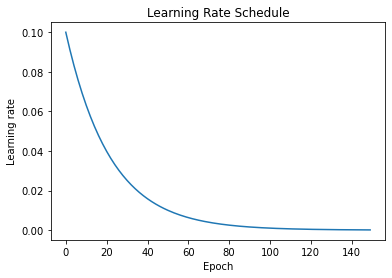

In [1107]:
# Set learning rate schedule
#learning_rate_schedule = [ (0.0, 1.0e-8), (0.2, 0.1), (0.6, 0.01), (0.9, 1.0e-6), (1.0, 1.0e-8)]

#lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)

epochs = 150

learning_rates = np.zeros(epochs)

for epoch in range(0, epochs):
  learning_rates[epoch] = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.1, decay_steps = -100, decay_rate = 100)

# Generate a tensor of 150 learning rates using TensorFlow operations
num_learning_rates = 150
learning_rate_range = tf.range(num_learning_rates, dtype=tf.float32)
learning_rates = learning_rate_schedule(learning_rate_range)

# Run a TensorFlow session to evaluate the learning rates
with tf.Session() as sess:
    learning_rates_array = sess.run(learning_rates)

print(type(learning_rates_array[0]))
    
learning_rates_array
plt.plot(range(0,150), learning_rates_array) 
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning Rate Schedule')

***Normalise data***

In [302]:
# basic data preparation
epsilon = 1.0e-08
def normalize_data(x_raw, y_raw, dydx_raw=None, crop=None):
    '''
    Input:
        x_raw      - raw inputs (asset prices)
        y_raw      - raw labels (option prices)
        dydx_raw   - raw differential labels (deltas)
        crop       - for cropping the data set (not important, ignore this)
    Output:
        x_mean     - mean of x_raw (asset prices)
        x_std      - standard deviation of x_raw (asset prices)
        x          - normalised asset prices (mean = 0, std = 1)
        y_mean     - mean of y_raw (option prices)
        y_std      - standard deviation of y_raw (option prices)
        y          - normalised option prices (mean = 0, std = 1)
        dy_dx      - 'normalised' differentials (deltas) (dy_dx = dydx_raw / y_std * x_std)
        lambda_j   - weight for Greek j in cost function (to keep magnitude of all the components of the cost function similar) irrelevant if we only have deltas, i.e., j = 1
        
  ''' 
    print(x_raw.shape, y_raw.shape)
    # crop dataset, otherwise leave as is if crop = None
    m = crop if crop is not None else x_raw.shape[0]
    x_cropped = x_raw[:m]
    y_cropped = y_raw[:m]
    dycropped_dxcropped = dydx_raw[:m] if dydx_raw is not None else None
    
    # normalize dataset
    x_mean = x_cropped.mean(axis=0)
    x_std = x_cropped.std(axis=0) + epsilon
    x = (x_cropped- x_mean) / x_std
    y_mean = y_cropped.mean(axis=0)
    y_std = y_cropped.std(axis=0) + epsilon
    y = (y_cropped-y_mean) / y_std
    
    # normalize derivatives too
    if dycropped_dxcropped is not None:
        dy_dx = dycropped_dxcropped / y_std * x_std 
        # weights of derivatives in cost function = (quad) mean size
        lambda_j = 1.0 / np.sqrt((dy_dx ** 2).mean(axis=0))#.reshape(1, -1)
    else:
        dy_dx = None
        lambda_j = None
    
    # We return the means and standard deviations so data can be 'unnormalised' when producing predictions
    return x_mean, x_std, x, y_mean, y_std, y, dy_dx, lambda_j

**Putting everything together**

In [1088]:
class Neural_Approximator():
    
    def __init__(self, x_raw, y_raw, 
                 dydx_raw=None):      # derivatives labels, 
       
        self.x_raw = x_raw
        self.y_raw = y_raw
        self.dydx_raw = dydx_raw
        
        # tensorflow logic
        self.graph = None
        
    def build_graph(self,
                differential,       # differential or not           
                lam,                # balance cost between values and derivs  
                hidden_units, 
                hidden_layers, 
                weight_seed):


        self.graph = tf.Graph()
        
        with self.graph.as_default():
        
            # build the graph, either vanilla or differential
            self.differential = differential
            
            if not differential:
            # vanilla 
                
                self.inputs, \
                self.labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer \
                = vanilla_training_graph(self.n, hidden_units, hidden_layers, weight_seed)
                    
            else:
            # differential
            
                if self.dy_dx is None:
                    raise Exception("No differential labels for differential training graph")
            
                self.alpha = 1.0/(1.0 + lam * self.n) # default is set them to 0.5 because self.n = 1
                self.beta = 1.0 - self.alpha
                
                self.inputs, \
                self.labels, \
                self.derivs_labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer = diff_training_graph(self.n, hidden_units, \
                                                     hidden_layers, weight_seed, \
                                                     self.alpha, self.beta, self.lambda_j)
        
            # global initializer
            self.initializer = tf.compat.v1.global_variables_initializer()
            
        # done
        self.graph.finalize()
        self.session = tf.compat.v1.Session(graph=self.graph)
                        
    # prepare for training with m examples, standard or differential
    def prepare(self, 
                m, 
                differential,
                #hidden_units = 20,
                lam=1,              # balance cost between values and derivs  
                # standard architecture
                hidden_units=20, 
                hidden_layers=4, 
                weight_seed=None):

        # prepare dataset
        self.x_mean, self.x_std, self.x, self.y_mean, self.y_std, self.y, self.dy_dx, self.lambda_j = \
            normalize_data(self.x_raw, self.y_raw, self.dydx_raw, m)
        
        # build graph        
        self.m, self.n = self.x.shape        
        self.build_graph(differential, lam, hidden_units, hidden_layers, weight_seed)
        
    def train(self,            
              description="training",
              # training params
              reinit=True, 
              epochs=150, 
              # one-cycle learning rate schedule
              learning_rate_schedule=[
                  (0.0, 1.0e-8), 
                  (0.2, 0.1), 
                  (0.6, 0.01), 
                  (0.9, 1.0e-6), 
                  (1.0, 1.0e-8)], 
              batches_per_epoch=16,
              min_batch_size=256,
              # callback and when to call it
              # we don't use callbacks, but this is very useful, e.g. for debugging
              callback=None,           # arbitrary callable
              callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
        t_loss = train(description, 
              self, 
              reinit, 
              epochs, 
              learning_rate_schedule, 
              batches_per_epoch, 
              min_batch_size,
              callback, 
              callback_epochs)
        return(t_loss)
     
    def predict_values(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std 
        # predict scaled
        y_scaled = self.session.run(self.predictions, feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        return y

    def predict_values_and_derivs(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std
        # predict scaled
        y_scaled, dyscaled_dxscaled = self.session.run(
            [self.predictions, self.derivs_predictions], 
            feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean[0] + self.y_std[0] * y_scaled
        #print(y)
        dydx = self.y_std[0] / self.x_std[0] * dyscaled_dxscaled
        return y, dydx
    
    def predict_unscaled(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std
        # predict scaled
        y_scaled, dyscaled_dxscaled = self.session.run(
            [self.predictions, self.derivs_predictions], 
            feed_dict = {self.inputs: x_scaled})
        return y_scaled, dyscaled_dxscaled

In [1104]:
#### Evaluation metrics

## Function to compute RMSE
def computeRmse(pred, true):
  errors = (pred - true)
  rmse = np.sqrt((errors ** 2).mean())
  return(rmse)

***Implementation***

In [1094]:
def test(generator,
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):
    
    # Add Heston test and train sets
    xTrain = X_train 
    yTrain = y_train 
    dydxTrain = dxdy_train 
    xTest = X_test 
    yTest = y_test
    dydxTest = dxdy_test
    xAxis = X_test
   
    # neural approximator
    print("initializing neural appropximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
            
        print("\nsize %d" % size)
        regressor.prepare(size, False, weight_seed=weightSeed)

        t0 = time.time()
        std_train_loss = regressor.train("standard training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("standard", size)] = predictions.reshape((-1,1))
        preddeltas[("standard", size)] = deltas[:, deltidx].reshape((-1,1))
        t1 = time.time()
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        t0 = time.time()
        diff_train_loss = regressor.train("differential training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("differential", size)] = predictions.reshape((-1,1))
        preddeltas[("differential", size)] = deltas[:, deltidx].reshape((-1,1))
        t1 = time.time()
        
    #return xAxis, yTest, dydxTest[:, deltidx], vegas, predvalues, preddeltas
    return xAxis, yTest, dydxTest, predvalues, preddeltas, std_train_loss, diff_train_loss

In [960]:
def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          size):
    
    numRows = 1  
    numCols = 2

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    ax[0, 0].set_title("Standard training")
    ax[0, 1].set_title("Differential training")

    for j, regType in enumerate(["standard", "differential"]):

        t = xAxisName

        ax[0, j].set_xlabel(t)
        ax[0, j].set_ylabel(yAxisName)

        ax[0, j].plot(xAxis, predictions[(regType, size)], 'co', \
                      markersize=2, markerfacecolor='white', label="Predicted values")
        ax[0, j].plot(xAxis, targets, 'r.', markersize=1, label='Target values')

        ax[0, j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.suptitle("%s - %s" % (title, yAxisName), fontsize=16)
    subtitle = "This is a subtitle"  # Customize the subtitle text
    fig.text(0.5, 0.88, "Training set size: " + str(size), ha='center', fontsize=12)  # Adjust the position and fontsize as needed
    plt.show()


In [1100]:
### Train and test the network

# simulation set sizes to perform
sizes = [800]

# show delta?
showDeltas = True

# number of test scenarios
nTest = 1   

# seed 42 

xAxis, yTest, dydxTest, values, deltas, std_train_loss, diff_train_loss = \
    test(generator = 'NA', sizes = sizes, 
         nTest = nTest, simulSeed = 42 , testSeed = 42, weightSeed = 42, deltidx=0)

initializing neural appropximator
done

size 800
(800, 1) (800, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


standard training:   0%|          | 0/150 [00:00<?, ?it/s]

(800, 1) (800, 1)


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

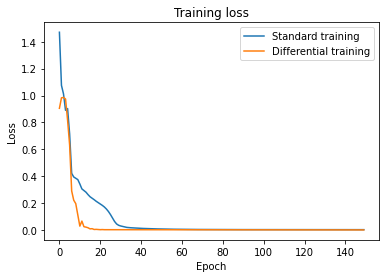

In [1101]:
### Plot training loss functions to check convergence
plt.plot(range(0,150), std_train_loss, label = 'Standard training')
plt.plot(range(0,150), diff_train_loss, label = 'Differential training')
plt.legend()
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

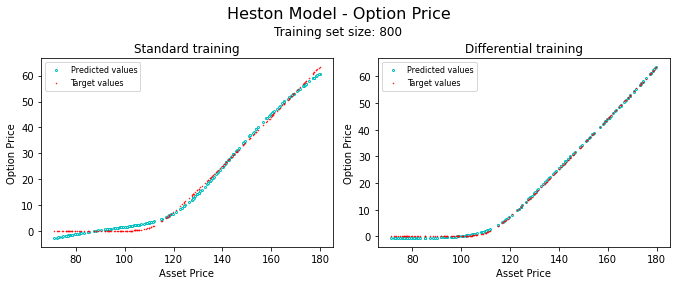

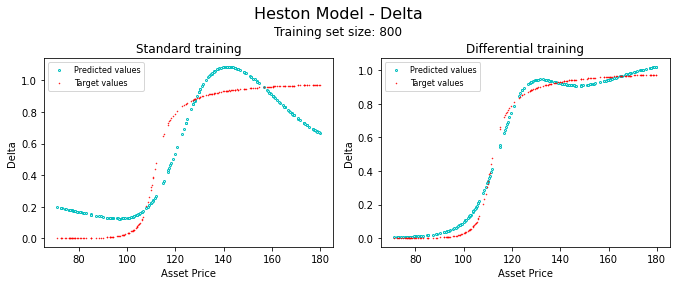

In [1102]:
### Plot predictions

# Prices
graph("Heston Model", values, xAxis, "Asset Price", "Option Price", y_test, size = 800)

# Deltas
graph("Heston Model", deltas, xAxis, "Asset Price", "Delta", dxdy_test, size = 800)

In [1105]:
### Make a results table

from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

sizes = 800

# Define the table data
results_table = [
    ["Option Prices", round(computeRmse(values['standard', sizes], y_test),3), round(computeRmse(values['differential', sizes], y_test),3),
     round(mean_absolute_error(values['standard', sizes], y_test),3), round(mean_absolute_error(values['differential', sizes], y_test),3)],
     #round(mean_absolute_percentage_error(values['standard', sizes], y_test),3), round(mean_absolute_percentage_error(values['differential', sizes], y_test),3)],
    ["Deltas", round(computeRmse(deltas['standard', sizes], dxdy_test),3), round(computeRmse(deltas['differential', sizes], dxdy_test), 3),
     round(mean_absolute_error(deltas['standard', sizes], dxdy_test),3), round(mean_absolute_error(deltas['differential', sizes], dxdy_test), 3)],
    #round(mean_absolute_percentage_error(deltas['standard', sizes], dxdy_test),3), round(mean_absolute_percentage_error(deltas['differential', sizes], dxdy_test),3)]
]

# Define the column names
column_names = ["Target Variable", "Standard", "Differential"] #"Standard", "Differential"]

# Convert the table to LaTeX format
latex_table = tabulate(results_table, headers=column_names, tablefmt="latex")

# Print the LaTeX table
print(latex_table)


\begin{tabular}{lrrrr}
\hline
               &       &   Target Variable &   Standard &   Differential \\
\hline
 Option Prices & 1.319 &             0.375 &      1.148 &          0.309 \\
 Deltas        & 0.154 &             0.043 &      0.136 &          0.035 \\
\hline
\end{tabular}


**Extras**

In [921]:
#### Perform grid search using cross validation

from sklearn.model_selection import KFold

hidden_units_grid = [5, 25, 50, 75, 100]
hidden_layers_grid = [1, 5, 10, 15, 20]

k_folds = 4

grid_search_results = pd.DataFrame(columns=["hidden_layers", "hidden_units", "val_loss"])

for hidden_layers in hidden_layers_grid:
    print(hidden_layers)
    for hidden_units in hidden_units_grid:
        print(hidden_units)
        
        # Perform k-fold cross-validation
        kf = KFold(n_splits=k_folds)
        rmse_prices_list = []
        rmse_deltas_list = []
        val_loss_list = []
        
        for train_indices, val_indices in kf.split(asset_prices):
            # Split data into train and validation sets
            x_train, x_val = asset_prices[train_indices], asset_prices[val_indices]
            y_train, y_val = payoffs[train_indices], payoffs[val_indices]
            dydx_train, dydx_val = differentials[train_indices], differentials[val_indices]
            
            # Prepare model
            regressor = Neural_Approximator(x_train, y_train, dydx_train)
            regressor.prepare(hidden_units=hidden_units, m= len(y_train), differential=True, weight_seed=42)
        
            
            # Train model
            regressor.train("differential training")
            
            # Get (unscaled) predictions
            predictions, deltas = regressor.predict_unscaled(x_val)
            
            # Compute validation loss
            y_val_scaled = (y_val - y_val.mean()) / y_val.std()
            dydx_val_scaled = dydx_val * (x_val.std() / y_val.std())            
            val_loss = 0.5 * mean_squared_error(predictions, y_val_scaled) + \
                       0.5 * mean_squared_error(deltas, dydx_val_scaled)
                
            print(val_loss)
            
            val_loss_list = val_loss_list + [val_loss]

        avg_val_loss = np.mean(val_loss_list)
        
        # Add results to table
        list_row = [hidden_layers, hidden_units, avg_val_loss]
        grid_search_results.loc[len(grid_search_results)] = list_row


1
5
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6969903596430184
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6843138872813408
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6904484353347435
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.678577106772168
25
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6971734753460317
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4645534908413738
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6908549734893382
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4674546648225653
50
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6976157474016422
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4645378974988175
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.46768613356659
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6787280918359837
75
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6971281445339372
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4649775465417663
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.0718767226452588
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4729755632417667
100
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.5175282263324967
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4985380022316082
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.507466891955402
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4707742879722998
5
5
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6976958178381664
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6842358779475297
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.690734856353805
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6800380654300234
25
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4757825797214137
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6833102414570046
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6909186796898792
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6779481314430151
50
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.8961972490477866
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.68494770179238
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6913403565137316
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.467472038092232
75
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4708925024331947
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.0617185740446273
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6914885297138965
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4739253333837459
100
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.5245907629770743
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4711806011307023
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.5031904490931427
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6795275221601286
10
5
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6970093044275958
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6837051758379296
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6906712957537406
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6780832737325957
25
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6974775215998927
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6838853525070315
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6909111806960437
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6780019555757648
50
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4757839905260113
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.464559361272234
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4677193802470017
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4674548867168327
75
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4788831374189388
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.695334457580318
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6924366947648439
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.468840089216246
100
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.5248901134567245
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6863723196389193
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.5118989186152172
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4980256245095545
15
5
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6970617146419557
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6836206003212943
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6907149315422336
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.678669611891171
25
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6972398593990861
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6838539223691777
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6904585872651838
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6787553864752214
50
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4757821402349334
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.150806248973933
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4677016639384277
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4674204446780688
75
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6979881264493438
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4655066984995604
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6905943450509052
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4696770088317854
100
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4757784863045702
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.5047340090216532
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4800097924785347
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6814464341438005
20
5
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6970741874743218
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6835409224231093
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6908951816231654
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6781870341681298
25
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.7276967903692152
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.7286602143443482
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6907779185027704
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6783143307792626
50
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.696921791628274
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6834777350110839
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

0.6909498088832065
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4674436126105677
75
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4779896345074535
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4646636372299948
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4675981654214187
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.468789524327641
100
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.5233692416129736
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.5055054562683532
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.4736529635655335
(75000, 1) (75000, 1)


<ipython-input-584-d0dc77e0e26f>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


differential training:   0%|          | 0/150 [00:00<?, ?it/s]

1.5104826805105083


In [923]:
## Save results
#import pickle 
#with open('grid_search_results.obj', 'wb') as file:
#    pickle.dump(grid_search_results, file)
    
### Load saved results
#with open('results_lstd.obj', 'rb') as file:
#    results_lstd = pickle.load(file)

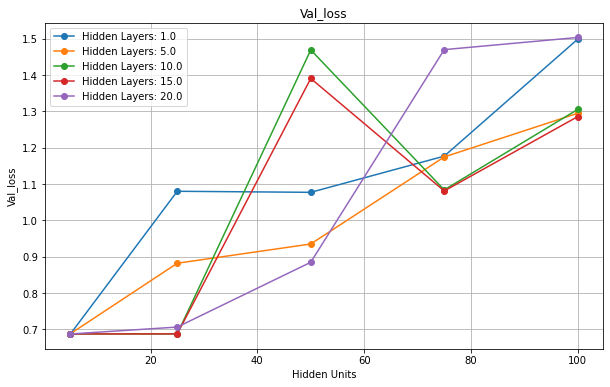

In [922]:
### Plot grid search results
metric = "val_loss"
filtered_results = grid_search_results[["hidden_layers", "hidden_units", metric]]

# Group the results by hidden_layers
grouped_results = filtered_results.groupby("hidden_layers")

plt.figure(figsize=(10, 6))
for hidden_layers, group in grouped_results:
    plt.plot(group["hidden_units"], group[metric], marker="o", label=f"Hidden Layers: {hidden_layers}")

plt.title(metric.capitalize())
plt.xlabel("Hidden Units")
plt.ylabel(metric.capitalize())
plt.legend()
plt.grid(True)
plt.show()
